# <center>Image captioning model training

In [1]:
# Project imports
from src.net.model import Model
from src.data_processing.dataset import Collate, Database, LmdbDataset
from src.data_processing.vocabulary import Vocabulary, TokenLabelConverter
from src.utils.predictor import Predictor
from src.utils.history import History
# Third party imports
import torch
import lightning as L
import numpy as np
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
from lightning.pytorch.loggers import CSVLogger
from multiprocessing import cpu_count
torch.set_float32_matmul_precision('high')

# Project constants
NUM_WORKERS = cpu_count()
MAX_EPOCHS = 30
BATCH_SIZE = 32
DATABASE_TRAIN_PATH = '/mnt/s/CV/data_lmdb_release/training/MJ/MJ_train'
DATABASE_VALID_PATH = '/mnt/s/CV/data_lmdb_release/training/MJ/MJ_valid'
DATABASE_TEST_PATH = '/mnt/s/CV/data_lmdb_release/training/MJ/MJ_test'
# Model hyperparametres
D_MODEL = 256
NUM_HEADS = 4
LR_START = 1e-4
GAMMA = 0.95

## Initialize vocabulary, datasets and dataloaders

In [2]:
vocab = TokenLabelConverter()

train_db = Database(DATABASE_TRAIN_PATH)
valid_db = Database(DATABASE_VALID_PATH)
test_db = Database(DATABASE_TEST_PATH)

dataset_train = LmdbDataset(train_db, vocab)
dataset_valid = LmdbDataset(valid_db, vocab)
dataset_test = LmdbDataset(test_db, vocab)

collate = Collate(pad_idx=vocab.dict['[s]'])
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=True, num_workers=NUM_WORKERS)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=False, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=True, num_workers=NUM_WORKERS)

print(f'Vocabulary size: {len(vocab)}')
print(f'Train size: {len(dataset_train)}')
print(f'Val/test size: {len(dataset_valid)}/{len(dataset_test)}')

Vocabulary size: 70
Train size: 7224586
Val/test size: 802731/891924


## Configure model and callbacks

In [3]:
# Model
config = dict(
    vocab=vocab,
    # d_model=D_MODEL,
    lr_start=LR_START,
    gamma=GAMMA
)
model = Model(**config).cuda()
# Callbacks and logger
logger = CSVLogger('logs')
lr_monitor_callback = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(
    dirpath='weights',
    filename='checkpoint',
    save_weights_only=True,
    mode='min',
    monitor='val_CE'
)
early_stop_callback = EarlyStopping(
    monitor='val_CE',
    min_delta=0.01,
    patience=5,
    mode='min'
)

## Training

In [4]:
trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    enable_checkpointing=True,
    callbacks=[
        checkpoint_callback,
        lr_monitor_callback,
        early_stop_callback
    ], 
    logger=logger, 
    log_every_n_steps=len(dataloader_train) # Every epoch
)
trainer.fit(model=model, train_dataloaders=dataloader_train, val_dataloaders=dataloader_valid)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/screamer/anaconda3/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: UserWarning:

Checkpoint directory /home/deep_learning/Text recognition/weights exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | encoder | ViTSTR | 85.9 M
-----------------------------------
85.9 M    Trainable params
0         Non-trainable params
85.9 M    Total params
343.410   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

torch.Size([32, 13, 70]) torch.Size([32, 13, 70])


ValueError: Expected input batch_size (416) to match target batch_size (29120).

## Evaluation on test set

In [ ]:
trainer.test(model, dataloaders=dataloader_test, ckpt_path='weights/checkpoint.ckpt');

Restoring states from the checkpoint path at weights/checkpoint.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at weights/checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_CE          │    1.8728206157684326     │
└───────────────────────────┴───────────────────────────┘

## Load best checkpoint and draw history

In [ ]:
model = model.__class__.load_from_checkpoint('weights/checkpoint.ckpt', vocab=vocab)

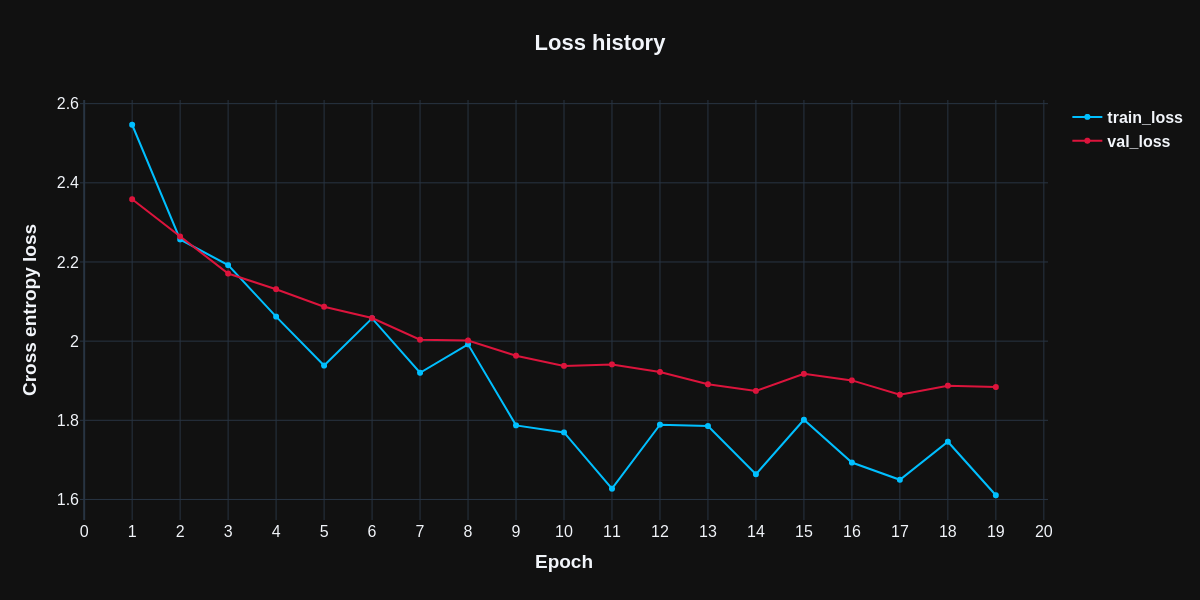

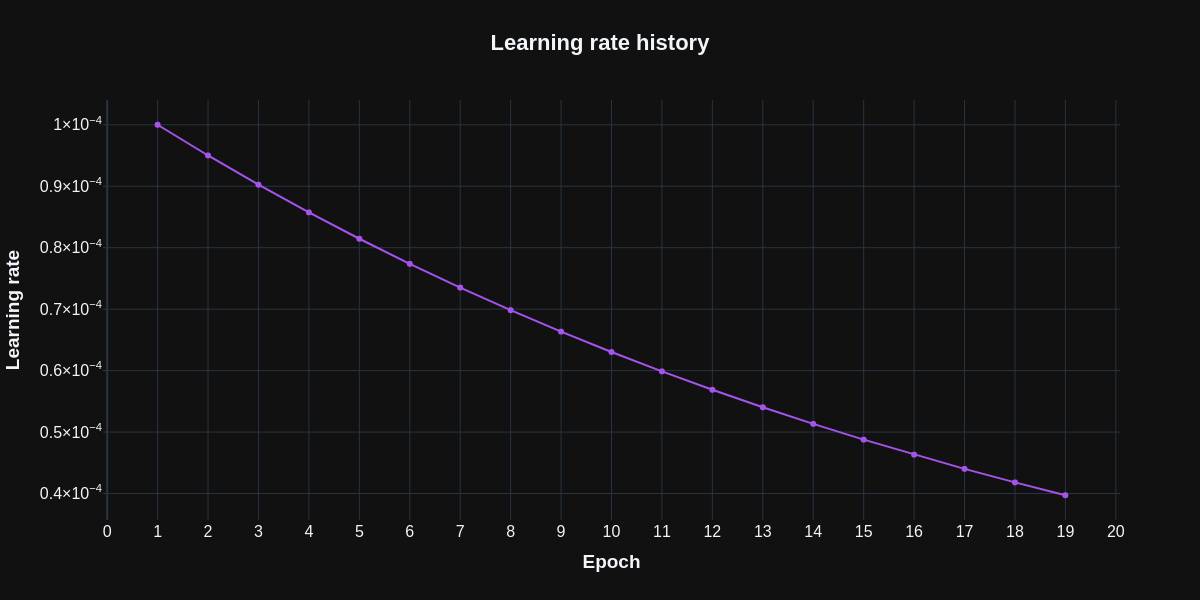

In [ ]:
history_visualizer = History('logs/lightning_logs/version_3/metrics.csv')
history_visualizer.draw_history()

## Visualize predictions from test set

o n e


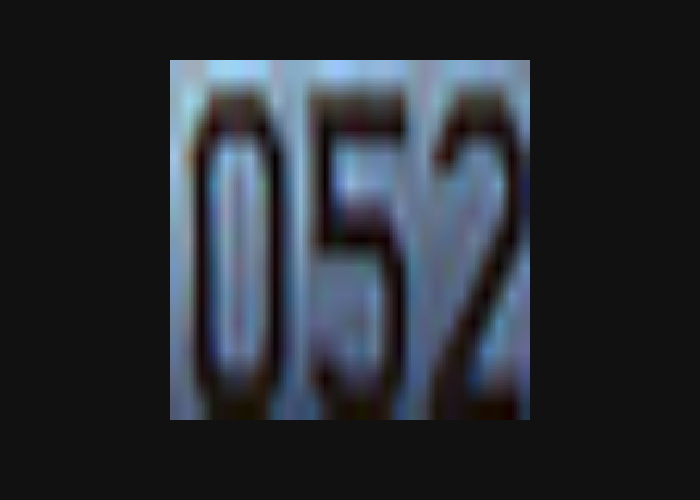

2


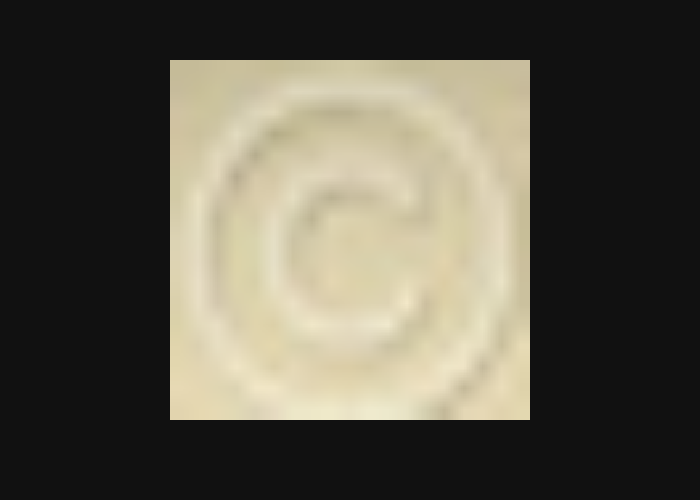

2 9


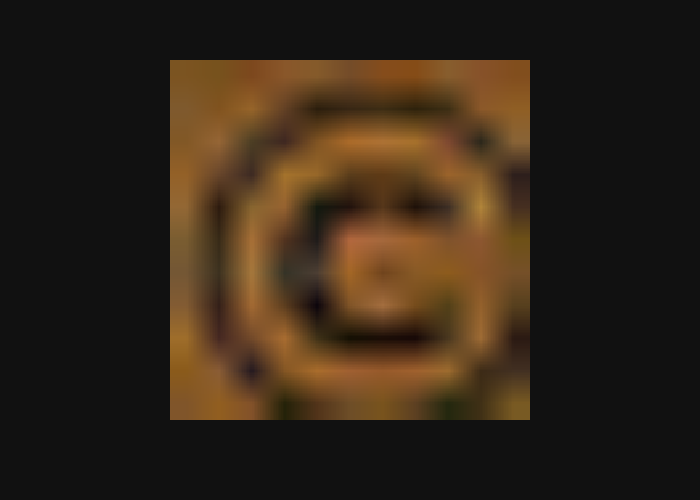

c h a r l e s


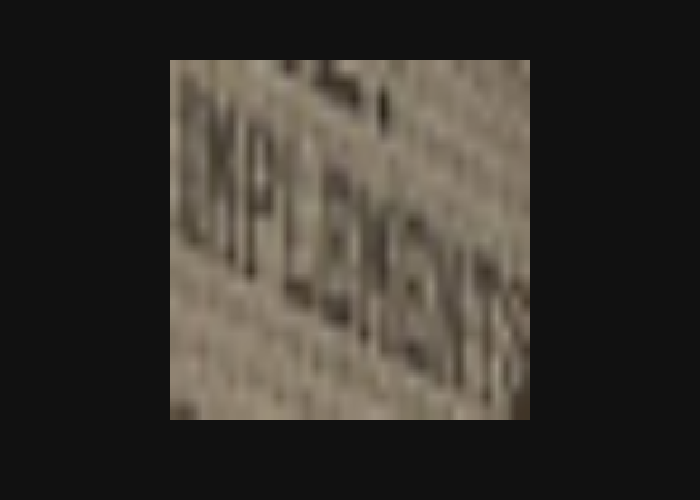

e


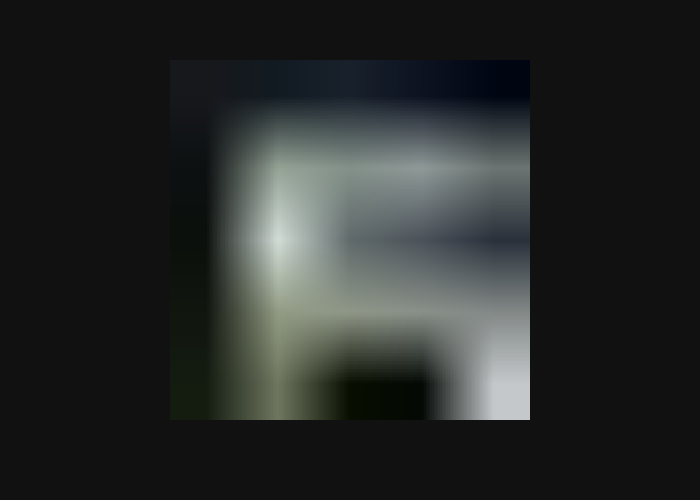

m a r k


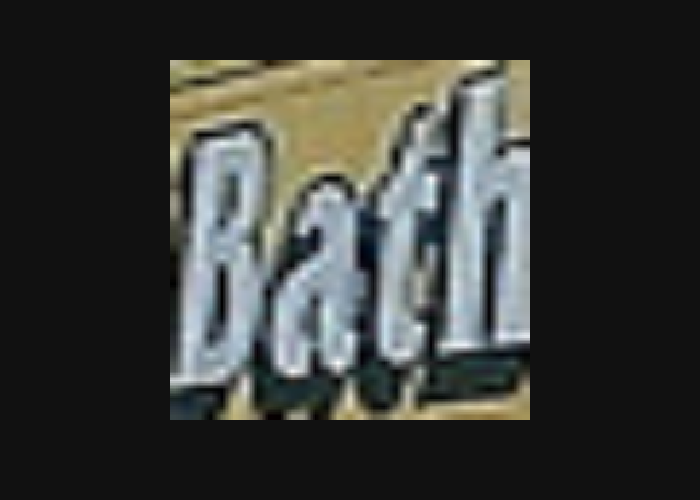

c o n s t r u c t i o n


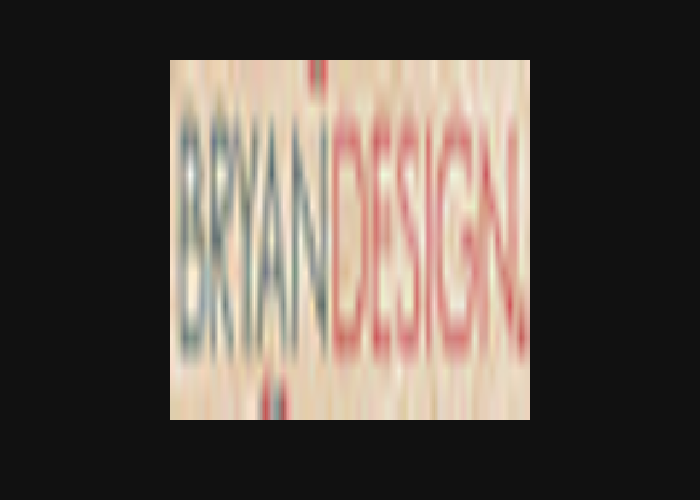

1 0


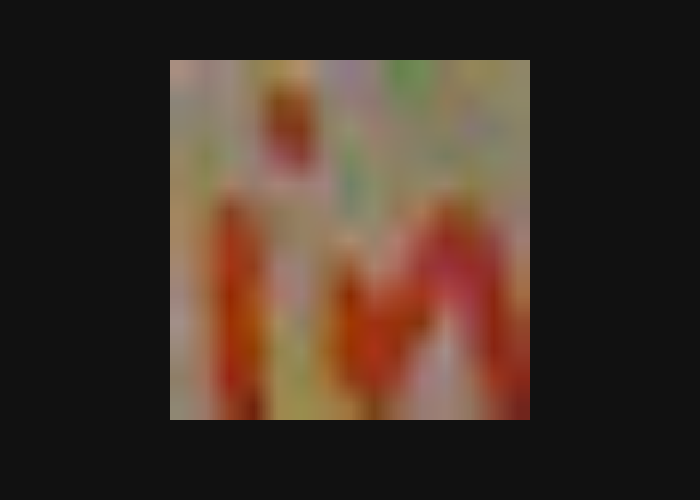

t o


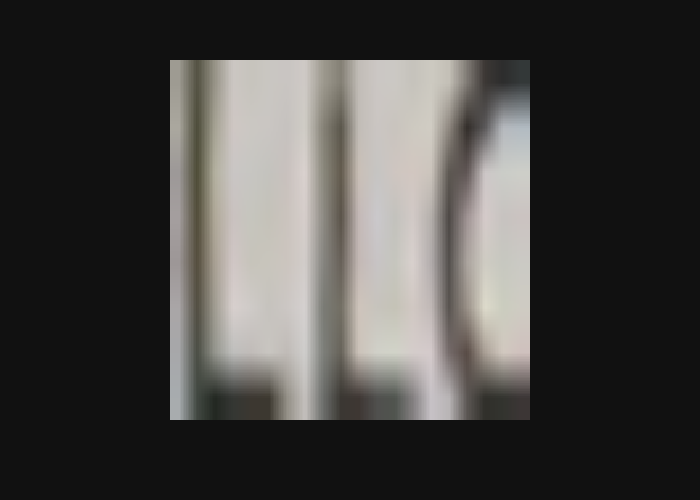

n o


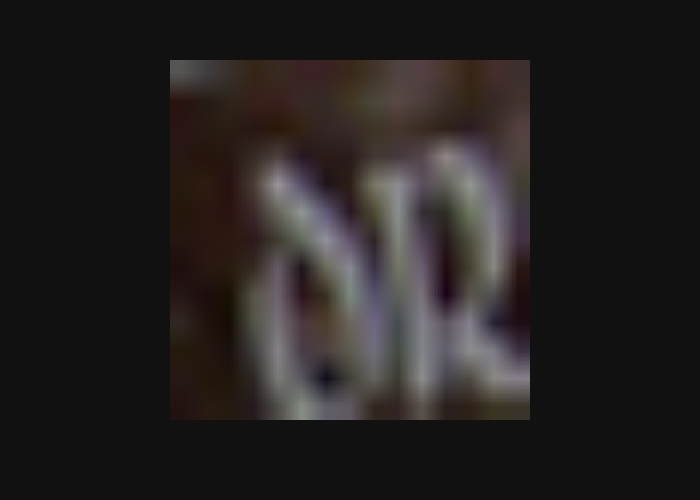

In [ ]:
predictions_visuazlier = Predictor()
predictions_visuazlier.caption_dataloader(dataloader=dataloader_test, model=model, n_samples=10)